## Malware Detection Using CNNs


In [2]:
import os
import numpy as np
from PIL import Image

**Data Processing**

In [5]:
def binary_file_to_image(filepath, size=(64, 64)):
    #open file and read binary  data
    with open(filepath, 'rb') as fname:
        byte_arr = np.frombuffer(fname.read(), dtype=np.uint8)
    
    # Flatten or pad the array to fit the target image size
    desired_size = size[0] * size[1]
    # Trucate if file size is too large
    if len(byte_arr) > desired_size:
        byte_arr = byte_arr[:desired_size]
    #Pad with zeros if file size is too small
    else:
        byte_arr = np.pad(byte_arr, (0, desired_size - len(byte_arr)), 'constant', constant_values=0)
    # returns image
    image = byte_arr.reshape(size)
    return image

In [7]:
#Define function to load the data set from the folders
def load_dataset(folder_path, size=(64, 64)): 
    # List X  to hold features and list Y variable holds class labels
    X, y = [], []
    for label, subfolder in enumerate(['ben', 'mal']):
        # prepares the subfolders 
        class_folder = os.path.join(folder_path, subfolder)
        for file_name in os.listdir(class_folder):
            file_path = os.path.join(class_folder, file_name)
        # Calls previous function to convert data to grayscale and resizes to 64 X 64
        # Then saves to X and Y
            try:
                img = binary_file_to_image(file_path, size)
                X.append(img)
                y.append(label)
        # If  file file is corrupt, error message will be printed and file will be skiped
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    # returns X and Y
    return np.array(X), np.array(y)

**Load and normalize**

In [10]:
import keras
from sklearn.model_selection import train_test_split


# Load datasets
train_X, train_y = load_dataset('/Users/dagim/Downloads/data_exe_100000/train/')
val_X, val_y = load_dataset('/Users/dagim/Downloads/data_exe_100000/valid/')
test_X, test_y = load_dataset('/Users/dagim/Downloads/data_exe_100000/test/')


# Normalize and reshape for CNN
train_X = train_X / 255.0
val_X = val_X / 255.0
test_X = test_X / 255.0

train_X = train_X[..., np.newaxis]
val_X = val_X[..., np.newaxis]
test_X = test_X[..., np.newaxis]

## Buliding Model

In [12]:
import keras
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=train_X.shape[1:] ),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.55),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,761 (3.13 MB)

 Trainable params: 821,761 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

**Configuring the model for training**

In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

**Early Stoping**

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    # will monitor val_loss
    monitor='val_loss', 
    # will wait 3 epochs to see if there is improvement
    patience=4, 
    # returns previous best model if there is no improvment
    restore_best_weights=True 
)

**Training the model**

In [24]:

history=model.fit(train_X, train_y, epochs=20, batch_size=32, callbacks=[early_stopping], validation_data=(val_X, val_y))

Epoch 1/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 61s 26ms/step - accuracy: 0.7166 - loss: 0.5397 - val_accuracy: 0.8378 - val_loss: 0.3566
Epoch 2/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 61s 26ms/step - accuracy: 0.8316 - loss: 0.3730 - val_accuracy: 0.8468 - val_loss: 0.3502
Epoch 3/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - accuracy: 0.8577 - loss: 0.3211 - val_accuracy: 0.8802 - val_loss: 0.2849
Epoch 4/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 59s 25ms/step - accuracy: 0.8779 - loss: 0.2821 - val_accuracy: 0.8824 - val_loss: 0.2728
Epoch 5/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - accuracy: 0.8897 - loss: 0.2557 - val_accuracy: 0.8922 - val_loss: 0.2600
Epoch 6/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 54s 23ms/step - accuracy: 0.8982 - loss: 0.2363 - val_accuracy: 0.8894 - val_loss: 0.2595
Epoch 7/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - accuracy: 0.9069 - loss: 0.2201 - val_accuracy: 0.9042 - val_loss: 0.2444
Epoch 8/20
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - accuracy: 0.9148 -

**Graphing the model**

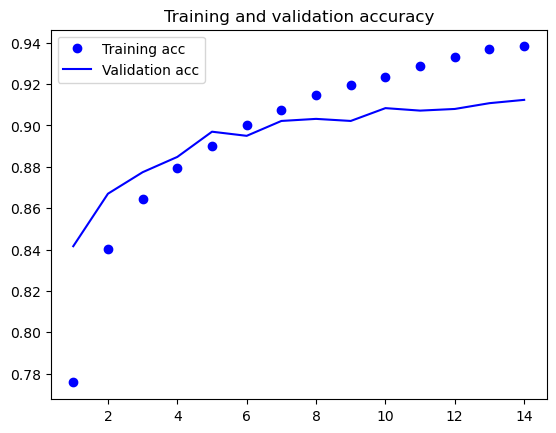

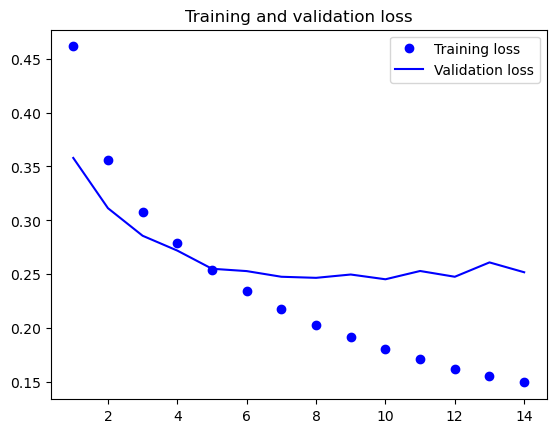

In [39]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Evaluating the model**

In [42]:
print ('\nTest')
test_loss, test_acc = model.evaluate(test_X, test_y)
print(f'test accuracy: {test_acc:.4f}')


Test
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9249 - loss: 0.2059
test accuracy: 0.9067


**Confusion Matrix**

In [45]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred=model.predict(test_X)
y_pred_classes =(y_pred > 0.5)
confmat=confusion_matrix(test_y,y_pred_classes)
print(confmat)

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
[[9337  663]
 [1203 8797]]
